In [1]:
using EzXML
using Plots
using NPZ
using Statistics
using StatsBase

# Autocorrelations

This notebook will plot the temporal autocorrelation for both the LFP and O2 data.

## Importing

In [2]:
# Get the XML metadata file

lfp_path = "Exp 2/R7/2022-05-11_17-39-17/Record Node 101/"
files_xml = root(readxml("../../data/$(lfp_path)Continuous_Data.openephys"))
sample_rate = parse(Int, firstelement(files_xml)["samplerate"])

recording = firstelement(firstelement(files_xml))

# Format XML data into Dict
files = Dict("processor" => recording["id"], "name" => [], "filename" => [], "position" => [], "bitVolts" => [])
for elem in eachelement(recording)
    push!(files["name"], elem["name"])
    filename = replace(elem["filename"], r"continuous$"=>"")
    push!(files["filename"], "$(filename)npz")
    push!(files["position"], elem["position"])
    push!(files["bitVolts"], elem["bitVolts"])
end

In [3]:
# Indexing lfp_data[channel, datapoint]

# Add data from each channel into a single matrix
n_datapoints = length(npzread("../../data/formatted-lfp/$(lfp_path)$(files["filename"][1])", ["data"])["data"][1:end-1024])
n_channels = length(files["filename"])
lfp_data = Array{Float32}(undef, n_channels, n_datapoints)
for i in 1:n_channels
    data = npzread("../../data/formatted-lfp/$(lfp_path)$(files["filename"][i])", ["data"])["data"][1:end-1024] .* parse(Float64, files["bitVolts"][i])
    lfp_data[i, :] = data
end

# Normalisation
for i in 1:n_channels
    lfp_data[i, :] = (lfp_data[i, :] .- mean(lfp_data[i, :])) ./ std(lfp_data[i, :])
end

In [4]:
# Add timestamps into vector 
# Timestamps are identical for each channel so this only needs to be done once
lfp_timestamps = npzread("../../data/formatted-lfp/$(lfp_path)$(files["filename"][1])", ["timestamps"])["timestamps"]
n_timestamps = length(lfp_timestamps)

lfp_timestamps_extended = [lfp_timestamps[i-1] + (lfp_timestamps[i] - lfp_timestamps[i-1]) * j / 1024 for i in 2:n_timestamps for j in 1:1024]
lfp_timestamps_extended ./= sample_rate

@assert length(lfp_timestamps_extended) == n_datapoints

# Indexing o2_data[datapoint, time/o2/flag]

o2_path = "Exp 2/R7/"
filename = "o2 r7.txt"
o2_data = []
open("../../data/$(o2_path)$(filename)") do file
    for line in eachline(file)
        if isdigit(line[1])
            data_element = split(line, "\t")  
            if length(data_element) == 3 && data_element[3] == "#* timeTick ON "
                data_element = [parse(Float32, data_element[1]), parse(Float32, data_element[2]), 1]
            else
                data_element = [parse(Float32, data_element[1]), parse(Float32, data_element[2]), 0]
            end
            push!(o2_data, data_element)
        end
    end
end
o2_data = reduce(vcat,transpose.(o2_data))

# Normalisation
o2_data[:,2] = (o2_data[:,2] .- mean(o2_data[:,2])) ./ std(o2_data[:,2])

1597615-element Vector{Float32}:
 -1.0974607
 -1.0974607
 -1.0974607
 -1.0974607
 -1.0974607
 -1.0974607
 -1.0974607
 -1.0974607
 -1.0974607
 -1.0974607
  ⋮
 -1.4199868
 -1.4199868
 -1.4199868
 -1.4199868
 -1.4199868
 -1.4199868
 -1.4199868
 -1.4199868
 -1.4199868

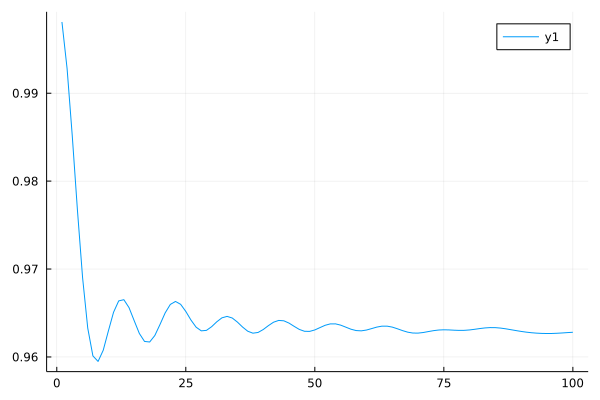

In [29]:
max_step = 1000000
#steps = (1:1000:max_step)
sample_size = 100000
#cors = [cor(o2_data[1:sample_size,2], o2_data[1+i:sample_size+i, 2]) for i in steps]
#plot(steps, cors)
cors = autocor(o2_data[1:end,2], (1:100))
plot(cors)